In [1]:
# IMPORTS
# Pandas is used for data manipulation
import pandas as pd
# Use numpy to convert to arrays
import numpy as np
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import tools needed for visualization
from sklearn.tree import export_graphviz
# import pydot
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# Utility to store and load model from disk
from sklearn.externals import joblib
# write csv files
import csv
# Import charting lib
import matplotlib.pyplot as plt

/anaconda3/envs/tf_gpu2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tf_gpu2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# UTIL
def test_model(forest_model, test_features, test_labels):
    # Use the forest's predict method on the test data
    predictions = np.round(forest_model.predict(test_features))

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    # Pull out one tree from the forest
    #tree = forest_model.estimators_[5]
    # print('The depth of this tree is:', tree.tree_.max_depth)

    total_trues = sum(x == 2 for x in test_labels)
    total_predictions = sum(x == 2 for x in predictions)
    total_errors = sum(x == 1 for x in errors)
    print('Total Samples:', len(test_labels))
    print('Total Trues:', total_trues)
    print('Total Predictions:', total_predictions)
    print('Total Errors:', total_errors)

    false_positive = sum(predict > label for predict, label in zip(predictions, test_labels))
    false_negative = sum(predict < label for predict, label in zip(predictions, test_labels))
    true_positive = total_predictions - false_positive
    print('false_positive:', false_positive)
    print('false_negative:', false_negative)
    print('true_positive:', true_positive)
    
    print('>>>>>>>>>>>>>>>>>>>>')
    for index, value in enumerate(zip(predictions, test_labels)):
        if value[0] < value[1]:
            print(test_features_[index,0])
    print('>>>>>>>>>>>>>>>>>>>>')
    
    
    precision = true_positive / total_predictions
    recall = true_positive / (true_positive + false_negative)
    print('precision:', precision)
    print('recall:', recall)
    return precision, recall

def draw_tree(forest_model, test_features, test_labels): 
    importances = forest_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(test_features.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(test_features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(test_features.shape[1]), indices)
    plt.xlim([-1, test_features.shape[1]])
    plt.show()    
    

In [3]:
# Prepare the source data
features = pd.read_csv('20181216_034921_pairs_final_enhanced_synt.csv') #20181020_212330_pairs_votes_enhanced

# Remove the irrelevant texts from the features
# axis 1 refers to the columns
# features = features.drop('fragmanetAndSide', axis = 1)
features = features.drop('fragment', axis = 1)
features = features.drop('fragmentAndSideTotal', axis = 1)
features = features.drop('fragmentAndSideTrend', axis = 1)
features = features.drop('fragmentAndSideCubes', axis = 1)
features = features.drop('fragmentAndSideDrawRect', axis = 1)
features = features.drop('fragmentAndSideMatchPoint', axis = 1)
features = features.drop('rotateFragmentAndSideCubes', axis = 1)
features = features.drop('rotateFragmentAndSideDrawRect', axis = 1)
features = features.drop('rotateFragmentAndSideMatchPoint', axis = 1)
features = features.drop('origCoordinates', axis = 1)
features = features.drop("firstFileName", axis = 1)
features = features.drop("firstCroppedWidth", axis = 1)
features = features.drop("firstOffsetX", axis = 1)
features = features.drop("firstOffsetY", axis = 1)
features = features.drop("firstHorizontalFlip", axis = 1)
features = features.drop("secondFileName", axis = 1)
features = features.drop("secondCroppedWidth", axis = 1)
features = features.drop("secondOffsetX", axis = 1)
features = features.drop("secondOffsetY", axis = 1)
features = features.drop("secondHorizontalFlip", axis = 1)
features = features.drop("prediction", axis = 1)

# features = features.drop('fragmentTotal', axis = 1)
# features = features.drop('fragmentAndSideVote', axis = 1)
# features = features.drop('fragmentAndSideTrendVote', axis = 1)

# One-hot encode categorical features
#features = pd.get_dummies(features)

# Labels are the values we want to predict
labels = np.array(features['class'])
labels = labels + 1

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('class', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

feature_list

['fragmentAndSide',
 'fragmentTotal',
 'fragmentVote',
 'devideVoteByTotal',
 'fragmentAndSideVote',
 'devideSideVoteBySideTotal',
 'fragmentAndSideTrendVote',
 'devideSideTrendVoteBySideTotal',
 'fragmentAndSideTrendVoteStrict',
 'devideSideTrendVoteStrictBySideTotal',
 'fragmentAndSideTrendVoteSync',
 'devideSideTrendVoteSyncBySideTotal',
 'votesOverlapMax',
 'divideOverlapMaxBySideTotal',
 'votesOverlapHeight',
 'votesSupportOverlapRect',
 'divideSupportOverlapBySideTotal',
 'divideSupportOverlapBySideVote']

Mean Absolute Error: 0.0
Accuracy: 99.94 %.
Total Samples: 839
Total Trues: 41
Total Predictions: 40
Total Errors: 1
false_positive: 0
false_negative: 1
true_positive: 40
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_6X3_3X2_0_PX303Fg006_6X3_4X2_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.975609756097561
Feature ranking:
1. feature 12 (0.342662)
2. feature 11 (0.240912)
3. feature 15 (0.162103)
4. feature 14 (0.157955)
5. feature 16 (0.026478)
6. feature 3 (0.017251)
7. feature 5 (0.015074)
8. feature 6 (0.008946)
9. feature 4 (0.006686)
10. feature 13 (0.006531)
11. feature 0 (0.004792)
12. feature 9 (0.003860)
13. feature 7 (0.002468)
14. feature 1 (0.001452)
15. feature 8 (0.001114)
16. feature 10 (0.001093)
17. feature 2 (0.000622)


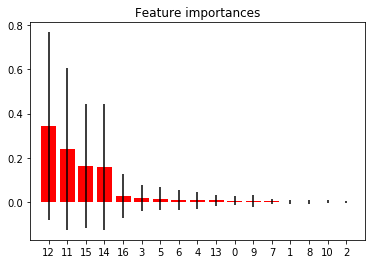

In [4]:
# Random Forest 1st model
# Split the data into training and testing sets
train_features_, test_features_, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)

train_features = train_features_[:,1:] # remove the fragmentAndSide column which is the label
test_features = test_features_[:,1:] # remove the fragmentAndSide column which is the label

# Instantiate model 
rf = RandomForestClassifier(n_estimators= 1000, random_state=42, n_jobs=-1)

rf.fit(train_features, train_labels)

test_model(rf, test_features, test_labels)
draw_tree(rf, test_features, test_labels)

In [6]:
# AdaBoostClassifier model 
ab = AdaBoostClassifier(n_estimators= 1000, learning_rate=0.8)

ab.fit(train_features, train_labels)

test_model(ab, test_features, test_labels)

Mean Absolute Error: 0.0
Accuracy: 99.94 %.
Total Samples: 815
Total Trues: 35
Total Predictions: 34
Total Errors: 1
false_positive: 0
false_negative: 1
true_positive: 34
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_5X3_3X1_1_PX303Fg006_5X3_4X1_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.971428571429


(1.0, 0.97142857142857142)

In [7]:
# BaggingClassifier model 
bc = BaggingClassifier(n_estimators= 1000)

bc.fit(train_features, train_labels)

test_model(bc, test_features, test_labels)

Mean Absolute Error: 0.0
Accuracy: 99.88 %.
Total Samples: 815
Total Trues: 35
Total Predictions: 33
Total Errors: 2
false_positive: 0
false_negative: 2
true_positive: 33
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_6X3_1X1_1_PX303Fg006_6X3_2X1_0
PX303Fg006_5X3_3X1_1_PX303Fg006_5X3_4X1_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.942857142857


(1.0, 0.94285714285714284)

In [8]:
# ExtraTreesClassifier model 
et = ExtraTreesClassifier(n_estimators= 1000)

et.fit(train_features, train_labels)

test_model(et, test_features, test_labels)

Mean Absolute Error: 0.0
Accuracy: 99.88 %.
Total Samples: 815
Total Trues: 35
Total Predictions: 33
Total Errors: 2
false_positive: 0
false_negative: 2
true_positive: 33
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_6X3_1X1_1_PX303Fg006_6X3_2X1_0
PX303Fg006_5X3_3X1_1_PX303Fg006_5X3_4X1_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.942857142857


(1.0, 0.94285714285714284)

In [9]:
# GradientBoostingClassifier model 
gb = GradientBoostingClassifier(n_estimators= 1000)

gb.fit(train_features, train_labels)

test_model(gb, test_features, test_labels)

Mean Absolute Error: 0.0
Accuracy: 99.88 %.
Total Samples: 815
Total Trues: 35
Total Predictions: 33
Total Errors: 2
false_positive: 0
false_negative: 2
true_positive: 33
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_6X3_1X1_1_PX303Fg006_6X3_2X1_0
PX303Fg006_5X3_3X1_1_PX303Fg006_5X3_4X1_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.942857142857


(1.0, 0.94285714285714284)

In [12]:
# VotingClassifier model 
vt = VotingClassifier(estimators=[('ab', ab), ('rf', rf), ('bc', bc), ('et', et), ('gb', gb)], voting='soft', n_jobs=-1)

vt.fit(train_features, train_labels)

test_model(vt, test_features, test_labels)

Mean Absolute Error: 0.0
Accuracy: 99.94 %.
Total Samples: 815
Total Trues: 33
Total Predictions: 32
Total Errors: 1
false_positive: 0
false_negative: 1
true_positive: 32
>>>>>>>>>>>>>>>>>>>>
PX303Fg006_3X2_1X1_1_PX303Fg006_3X2_2X1_0
>>>>>>>>>>>>>>>>>>>>
precision: 1.0
recall: 0.969696969697


(1.0, 0.96969696969696972)

In [ ]:
# from sklearn.model_selection import cross_val_predict
# from sklearn import metrics
# predicted = cross_val_predict(rf, test_features, test_labels, cv=5)
# metrics.accuracy_score(test_labels, np.round(predicted)) 


In [ ]:
# Random Forest 2nd variation of model - just for reference - not used
rf_new = RandomForestRegressor(n_estimators = 1000, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)
rf_new.fit(train_features, train_labels)

test_model(rf_new, test_features, test_labels)

In [ ]:
# Random Forest 3rd model - Limit depth of tree to 2 levels - not used
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

test_model(rf_small, test_features, test_labels)

In [5]:
# Finally - use the 1st model and this time train on the entire set 
fit_features = features[:,1:] # remove the fragmentAndSide column which is the label

rf.fit(fit_features, labels);

joblib.dump(rf, 'rndFstBasic2.pkl') 

['rndFstBasic2.pkl']

In [6]:
# Run on the output of the voting and classify them
# Read in data as pandas dataframe
orig_features = pd.read_csv('20181216_034921_pairs_final_enhanced_synt.csv') #('20181213_031300_pairs_final_flipped_enhanced.csv')

# Remove the irrelevant texts from the features
# axis 1 refers to the columns
features = orig_features.drop('fragmentAndSide', axis = 1)
features = features.drop('fragment', axis = 1)
features = features.drop('fragmentAndSideTotal', axis = 1)
features = features.drop('fragmentAndSideTrend', axis = 1)
features = features.drop('fragmentAndSideCubes', axis = 1)
features = features.drop('fragmentAndSideDrawRect', axis = 1)
features = features.drop('fragmentAndSideMatchPoint', axis = 1)
features = features.drop('rotateFragmentAndSideCubes', axis = 1)
features = features.drop('rotateFragmentAndSideDrawRect', axis = 1)
features = features.drop('rotateFragmentAndSideMatchPoint', axis = 1)
features = features.drop('origCoordinates', axis = 1)
features = features.drop("firstFileName", axis = 1)
features = features.drop("firstCroppedWidth", axis = 1)
features = features.drop("firstOffsetX", axis = 1)
features = features.drop("firstOffsetY", axis = 1)
features = features.drop("firstHorizontalFlip", axis = 1)
features = features.drop("secondFileName", axis = 1)
features = features.drop("secondCroppedWidth", axis = 1)
features = features.drop("secondOffsetX", axis = 1)
features = features.drop("secondOffsetY", axis = 1)
features = features.drop("secondHorizontalFlip", axis = 1)
features = features.drop("class", axis = 1)
features = features.drop("prediction", axis = 1)

forest_model = joblib.load('rndFstBasic2.pkl') 

predictions = np.round(forest_model.predict(features))-1
orig_features["prediction"] = predictions
filtered = orig_features # [orig_features["prediction"] == 1]
filtered.to_csv('20181216_034921_pairs_final_enhanced_final_synt2.csv', index=False)